# 014. Feature selection

We want to shortly investigate, which features might carry the most potential for the use in the LocalModel. Therefor, the data in a small region is again averaged, which results in a single time series for each feature, as well as a single predictand time series, against which the features are compared to.

As we want to limit the features for the LocalModel, which is supposed to predict the leftover residuals from the TransportModel mainly consisting of the local impacts arising from precipitation and other corresponding variables, we filter the data in the time dimension to only incude days with measurable amounts of precipitation recorded and furthermore look at the change of discharge from one day to another, instead of absolute values.

To quantify the impact of each feature, we use a filter method with the pearson correlation coefficient.

In [1]:
import os, warnings
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

import dask
dask.config.set(scheduler='threading')

import xarray as xr
from dask.diagnostics import ProgressBar
from joblib import Parallel

In [2]:
import link_src
from python.aux.utils import open_data
from python.aux.ml_flood_config import path_to_data

In [3]:
from python.aux.ml_flood_config import path_to_data
from python.aux.utils import open_data
from python.aux.utils import shift_time
# define some vars
data_path = f'{path_to_data}danube/'
print(data_path)

/home/srvx11/lehre/users/a1303583/ipython/ml_flood/data/danube/


In [4]:
# load data
era5 = open_data(data_path, kw='era5')
glofas = open_data(data_path, kw='glofas_ra')
glofas = shift_time(glofas, -dt.timedelta(days=1))

In [34]:
def feature_preproc(era5, glofas, timeinit, timeend):
    def add_shifted_predictors(ds, shifts, variables='all'):
        """Adds additional variables to an array which are shifted in time.

        Parameters
        ----------
        ds : xr.Dataset
        shifts : list of integers
        variables : str or list
        """
        if variables == 'all': 
            variables = ds.data_vars

        for var in variables:
            for i in shifts:
                if i == 0: continue  # makes no sense to shift by zero
                newvar = var+'-'+str(i)
                ds[newvar] = ds[var].shift(time=i)
        return ds
    
    if not 'lsp' in era5:
        lsp = era5['tp']-era5['cp']
        lsp.name = 'lsp'
    else:
        lsp = era5['lsp']

    reltop = era5['z'].sel(level=500) - era5['z'].sel(level=850)
    reltop.name = 'reltop'

    q_mean = era5['q'].mean('level')
    q_mean.name = 'q_mean'

    t_mean = era5['t'].mean('level')
    t_mean.name = 't_mean'

    ro = era5['ro']
    ro.name = 'ro'
    swvl1 = era5['swvl1']
    swvl1.name = 'swvl1'
    swvl2 = era5['swvl2']
    swvl2.name = 'swvl2'
    tcwv = era5['tcwv']
    tcwv.name = 'tcwv'
    slt = era5['slt']
    slt.name = 'slt'
    z_topo = era5['z_topo']
    z_topo.name = 'z_topo'
    slor = era5['slor']
    slor.name = 'slor'
    lsm = era5['lsm']
    lsm.name = 'lsm'


    era5_features = xr.merge([era5['cp'], lsp, reltop, q_mean, t_mean, ro, swvl1, swvl2, tcwv])

    era5_features = era5_features.interp(latitude=glofas.latitude,
                                         longitude=glofas.longitude)
#    era5_features = era5_features.isel(time=slice(0*365,3*365))
    era5_features = era5_features.sel(time=slice(timeinit, timeend))
    
#    glofas = glofas.isel(time=slice(0*365,3*365))
    glofas = glofas.sel(time=slice(timeinit, timeend))

    if len(era5_features.time) < 3000:
        era5_features = era5_features.load()
        glofas = glofas.load()

    krems = dict(latitude=48.403, longitude=15.615)

    local_region = dict(latitude=slice(krems['latitude']+1.5, 
                                       krems['latitude']-1.5),
                       longitude=slice(krems['longitude']-1.5, 
                                       krems['longitude']+1.5))

    # select area of interest and average over space for all features
    dis = glofas.interp(krems)
    y = dis.diff('time', 1)
    X = era5_features.sel(local_region).mean(['latitude', 'longitude'])
    #print(X)
    shifts = range(1,3)
    notshift_vars = ['swvl1', 'swvl2']
    shift_vars = [v for v in X.data_vars if not v in notshift_vars]

    Xs = add_shifted_predictors(X, shifts, variables=shift_vars)
    Xar = Xs.to_array(dim='features')
    yar = y.to_array()

    # singleton dimension has to have the same name like in X
    # so we set it to 'features' too
    yar = yar.rename({'variable': 'features'})

    # it confuses the concat if one has latitude but the other not
    yar = yar.drop(['latitude', 'longitude'])
    Xy = xr.concat([Xar, yar], dim='features')  

    # drop them as we cannot train on nan values
    Xyt = Xy.dropna('time', how='any')
    predictand = 'dis'
    predictors = [v for v in Xyt.coords['features'].values if v != predictand]
    Xda = Xyt.loc[predictors]
    yda = Xyt.loc[predictand]
    time = yda.time
    #Xda = Xda.chunk(dict(time=-1, features=-1)).data.T
    #yda = yda.data.squeeze()
    return Xda, yda

In [35]:
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

def generate_heatmap(X, y, descr='description'):
    df = pd.DataFrame(data=X.T.values, columns=X.features.values, index=X.time.values)
    df['predictand'] = y
    plt.figure(figsize=(25,25))
    cor = df.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()
    cor_predictand = abs(cor['predictand'])
    feature_importance = cor_predictand[cor_predictand > 0.2]
    print(descr)
    print(feature_importance)
    return feature_importance

Now that all methods are set up, lets have a look at different time periods and generate a correlation heatmap between all features, with a printed list of features >0.2 correlation coeff at the end. Lets also save the important feature into a new list and evaluate it at the end.

In [36]:
important_features = []

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


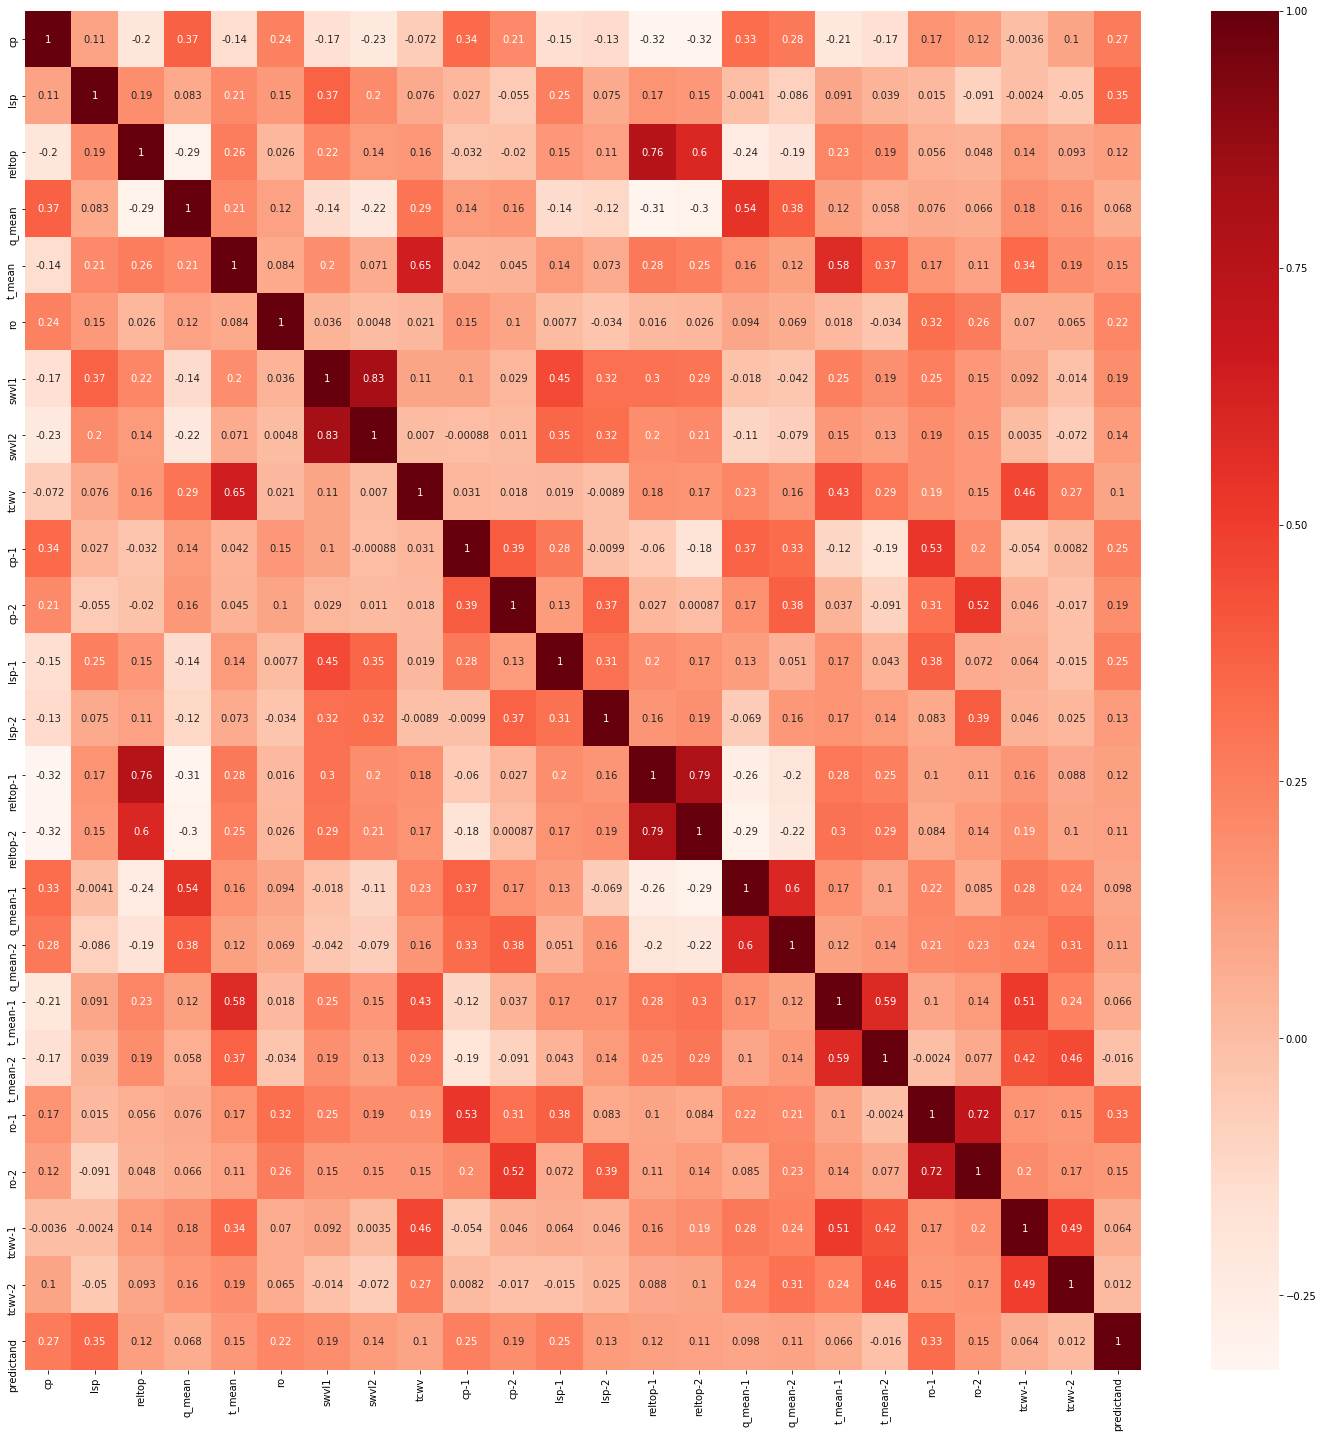

1980-01-01-1992-12-31; only days with precip > 1mm
cp            0.270698
lsp           0.345495
ro            0.221732
cp-1          0.252466
lsp-1         0.250437
ro-1          0.330648
predictand    1.000000
Name: predictand, dtype: float64


In [37]:
timeinit = '1980-01-01'
timeend = '1992-12-31'
X, y = feature_preproc(era5=era5, glofas=glofas, timeinit=timeinit, timeend=timeend)
Xtp = X.sel(features='cp') + X.sel(features='lsp')
Xprecip = Xtp.where(Xtp>1/1000, drop=True)
X = X.where(Xprecip)
y = y.where(Xprecip)
ft = generate_heatmap(X=X, y=y, descr=f'{timeinit}-{timeend}; only days with precip > 1mm')
important_features.append(ft)

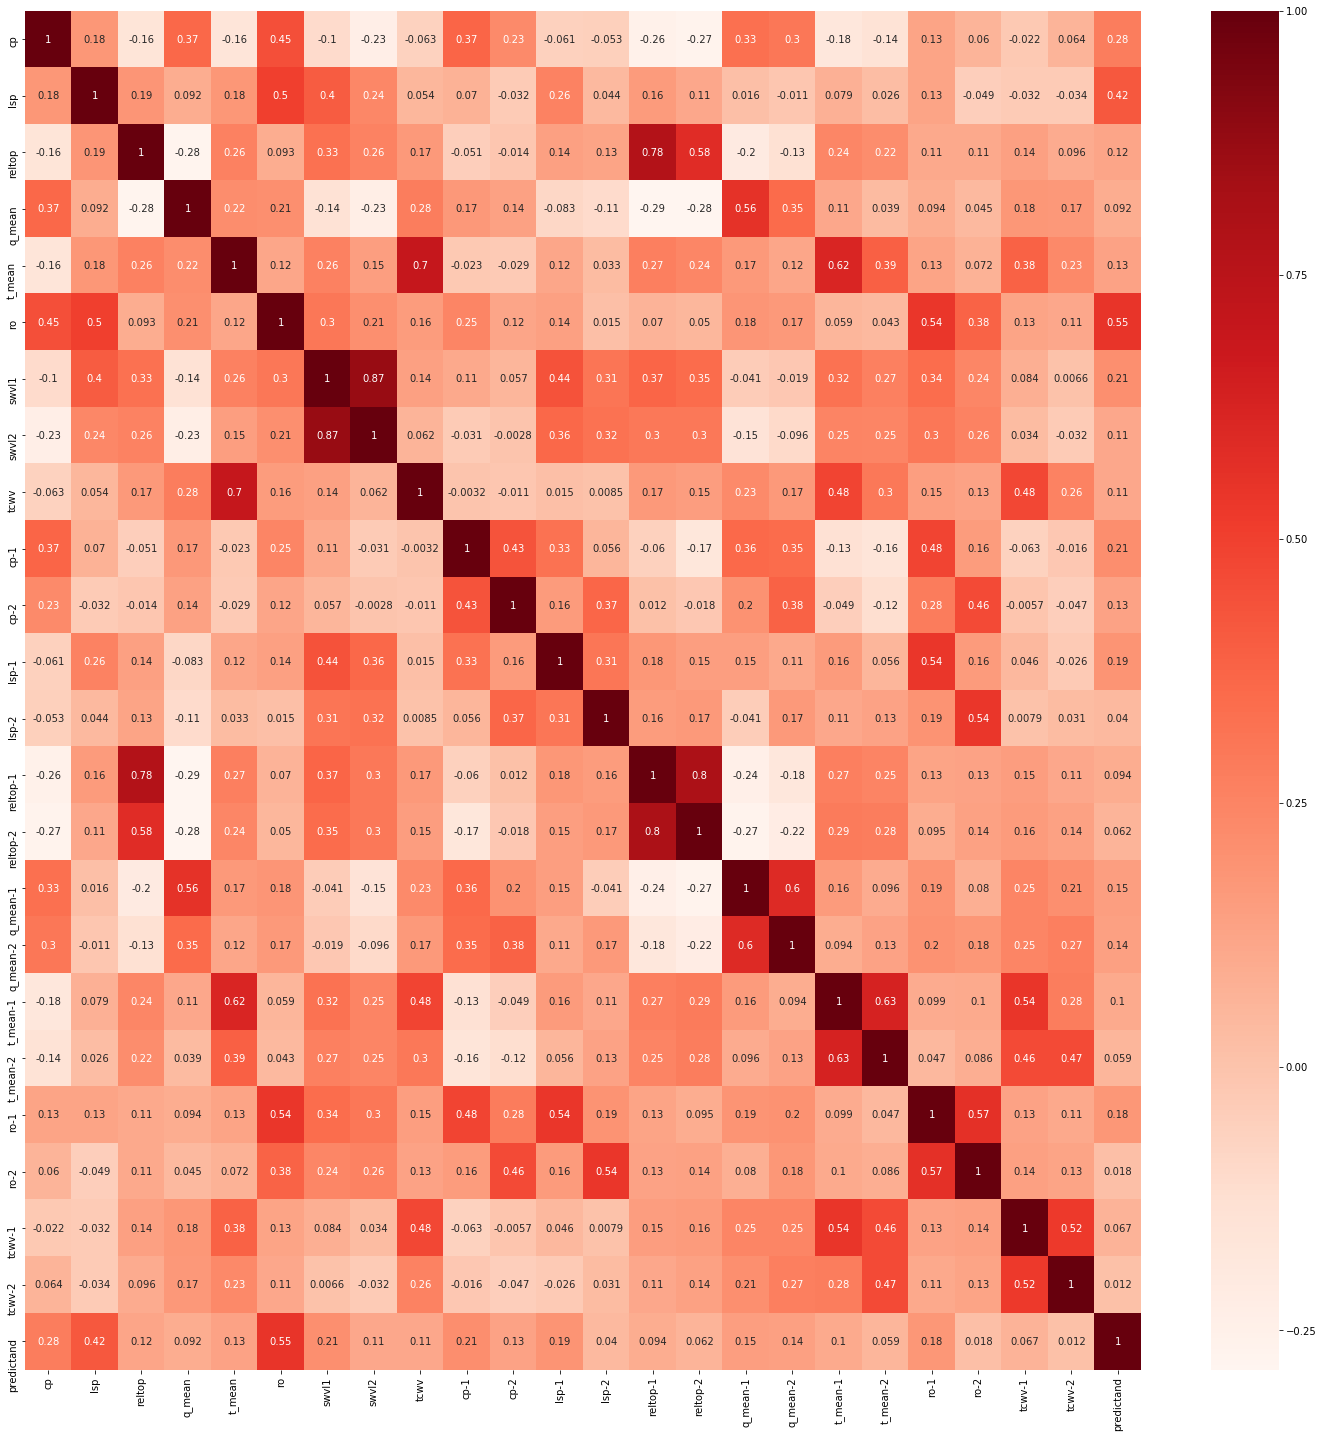

1993-01-01-2005-12-31; only days with precip > 1mm
cp            0.277716
lsp           0.420385
ro            0.551102
swvl1         0.206962
cp-1          0.211244
predictand    1.000000
Name: predictand, dtype: float64


In [38]:
timeinit = '1993-01-01'
timeend = '2005-12-31'
X, y = feature_preproc(era5=era5, glofas=glofas, timeinit=timeinit, timeend=timeend)
Xtp = X.sel(features='cp') + X.sel(features='lsp')
Xprecip = Xtp.where(Xtp>1/1000, drop=True)
X = X.where(Xprecip)
y = y.where(Xprecip)
ft = generate_heatmap(X=X, y=y, descr=f'{timeinit}-{timeend}; only days with precip > 1mm')
important_features.append(ft)

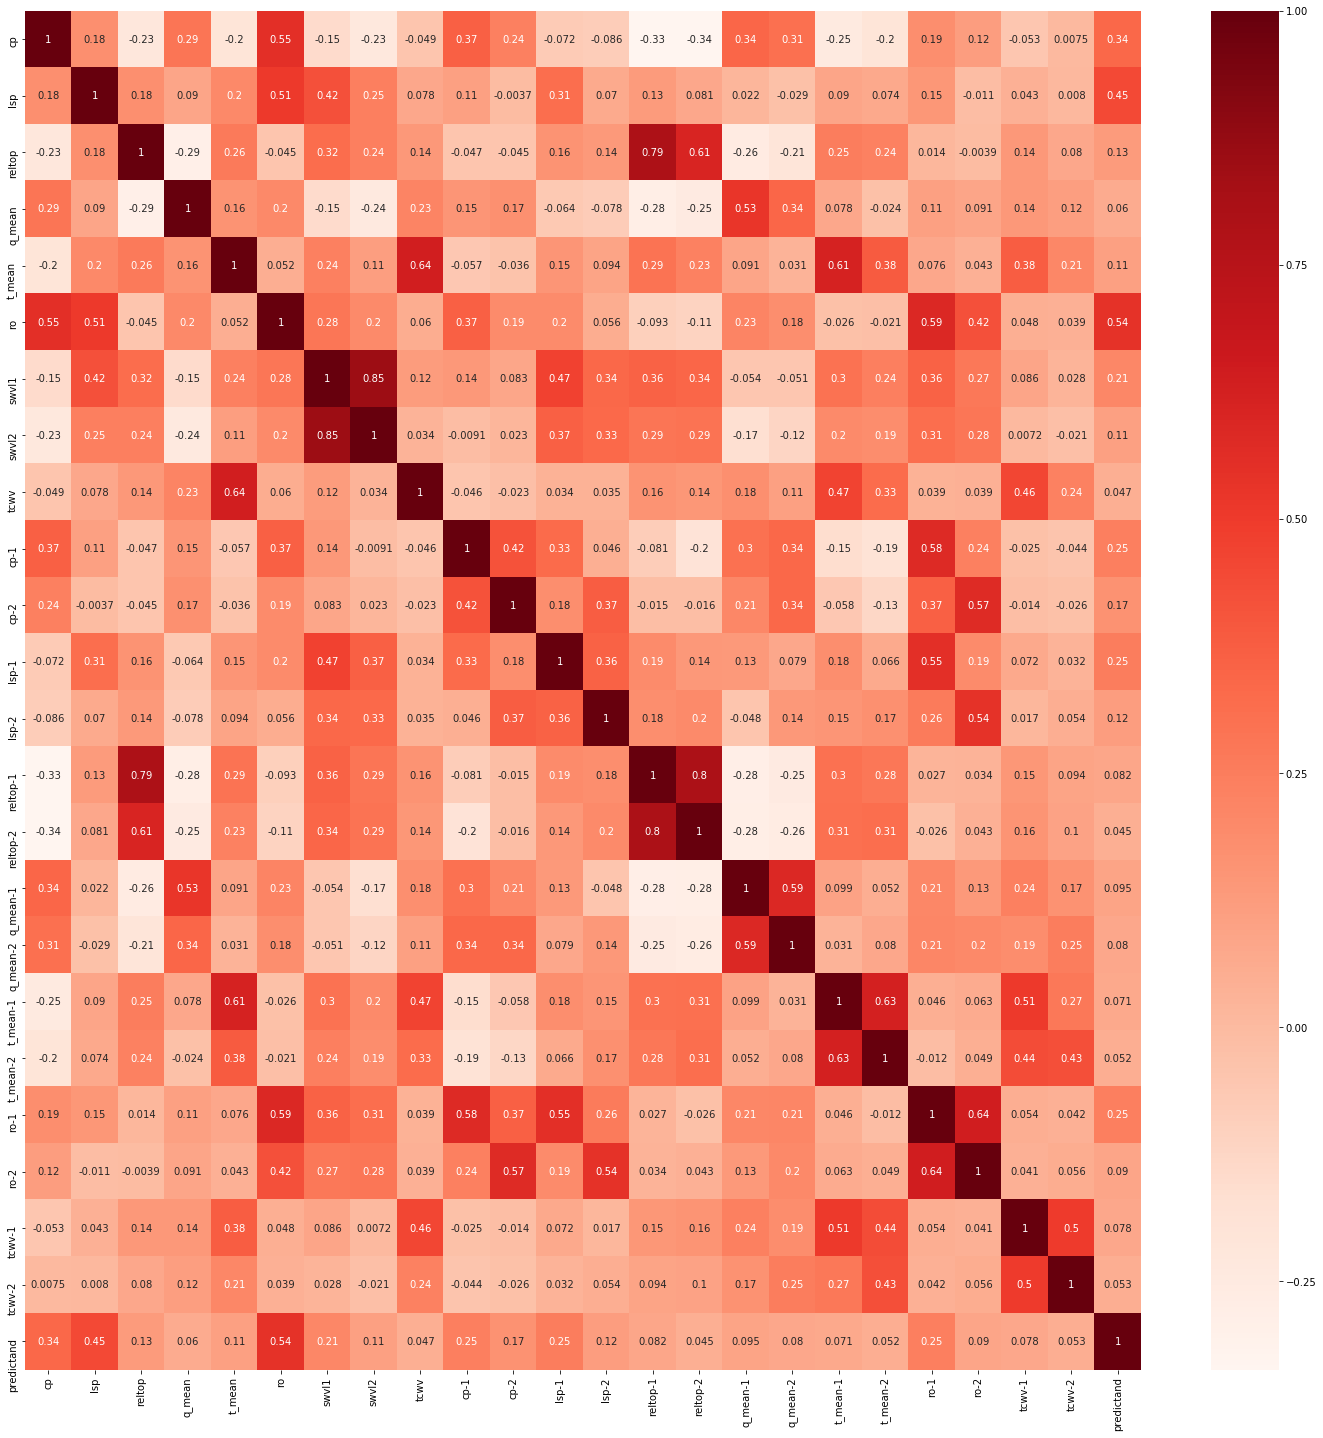

2006-01-01-2017-12-31; only days with precip > 1mm
cp            0.340097
lsp           0.451370
ro            0.544019
swvl1         0.206912
cp-1          0.247660
lsp-1         0.249083
ro-1          0.246982
predictand    1.000000
Name: predictand, dtype: float64


In [39]:
timeinit = '2006-01-01'
timeend = '2017-12-31'
X, y = feature_preproc(era5=era5, glofas=glofas, timeinit=timeinit, timeend=timeend)
Xtp = X.sel(features='cp') + X.sel(features='lsp')
Xprecip = Xtp.where(Xtp>1/1000, drop=True)
X = X.where(Xprecip)
y = y.where(Xprecip)
ft = generate_heatmap(X=X, y=y, descr=f'{timeinit}-{timeend}; only days with precip > 1mm')
important_features.append(ft)

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


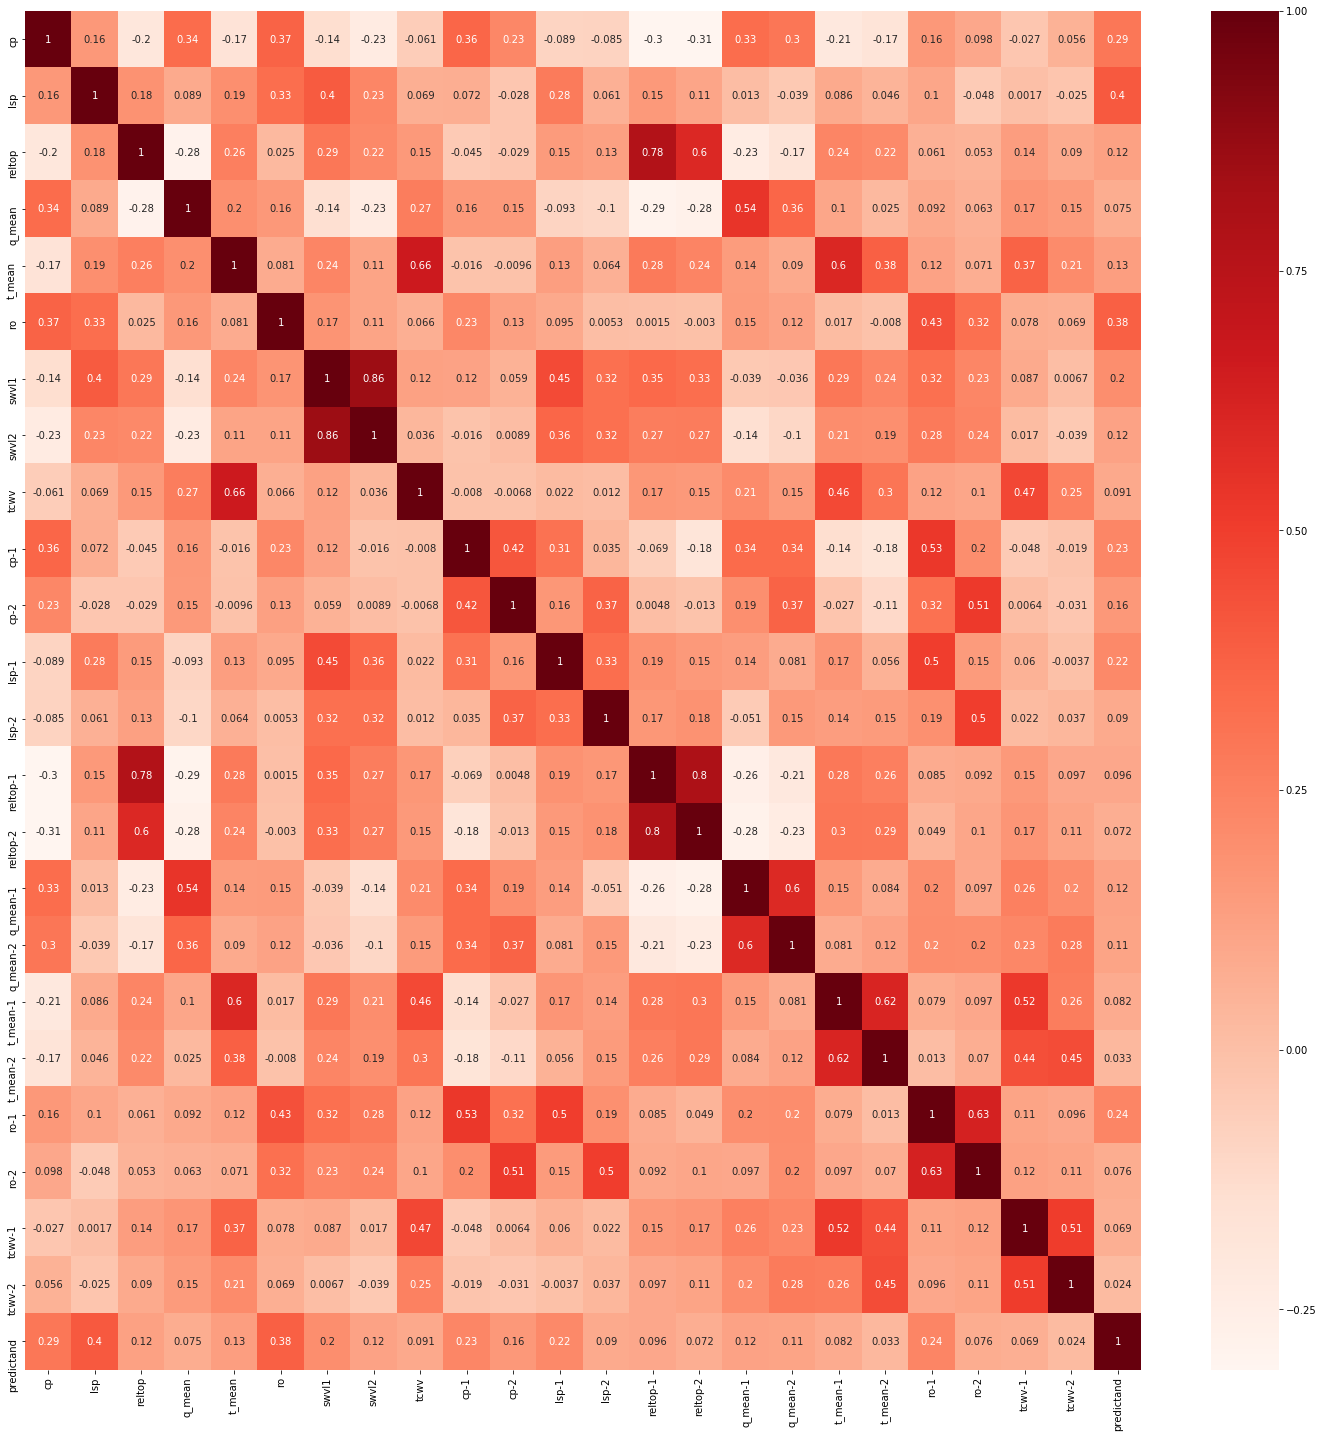

1980-01-01-2017-12-31; only days with precip > 1mm
cp            0.291124
lsp           0.403068
ro            0.381352
swvl1         0.201627
cp-1          0.232101
lsp-1         0.222051
ro-1          0.238323
predictand    1.000000
Name: predictand, dtype: float64


In [40]:
timeinit = '1980-01-01'
timeend = '2017-12-31'
X, y = feature_preproc(era5=era5, glofas=glofas, timeinit=timeinit, timeend=timeend)
Xtp = X.sel(features='cp') + X.sel(features='lsp')
Xprecip = Xtp.where(Xtp>1/1000, drop=True)
X = X.where(Xprecip)
y = y.where(Xprecip)
ft = generate_heatmap(X=X, y=y, descr=f'{timeinit}-{timeend}; only days with precip > 1mm')
important_features.append(ft)

Looking at long periods of time the resulting feature importance is:

cp, lsp, ro, cp-1, lsp-1, ro-1, swvl1

In [62]:
for entry in important_features:
    print(entry[:-1])
    print('#'*30)

cp       0.270698
lsp      0.345495
ro       0.221732
cp-1     0.252466
lsp-1    0.250437
ro-1     0.330648
Name: predictand, dtype: float64
##############################
cp       0.277716
lsp      0.420385
ro       0.551102
swvl1    0.206962
cp-1     0.211244
Name: predictand, dtype: float64
##############################
cp       0.340097
lsp      0.451370
ro       0.544019
swvl1    0.206912
cp-1     0.247660
lsp-1    0.249083
ro-1     0.246982
Name: predictand, dtype: float64
##############################
cp       0.291124
lsp      0.403068
ro       0.381352
swvl1    0.201627
cp-1     0.232101
lsp-1    0.222051
ro-1     0.238323
Name: predictand, dtype: float64
##############################


Lastly, we look at a specific flooding example: May/June 2013

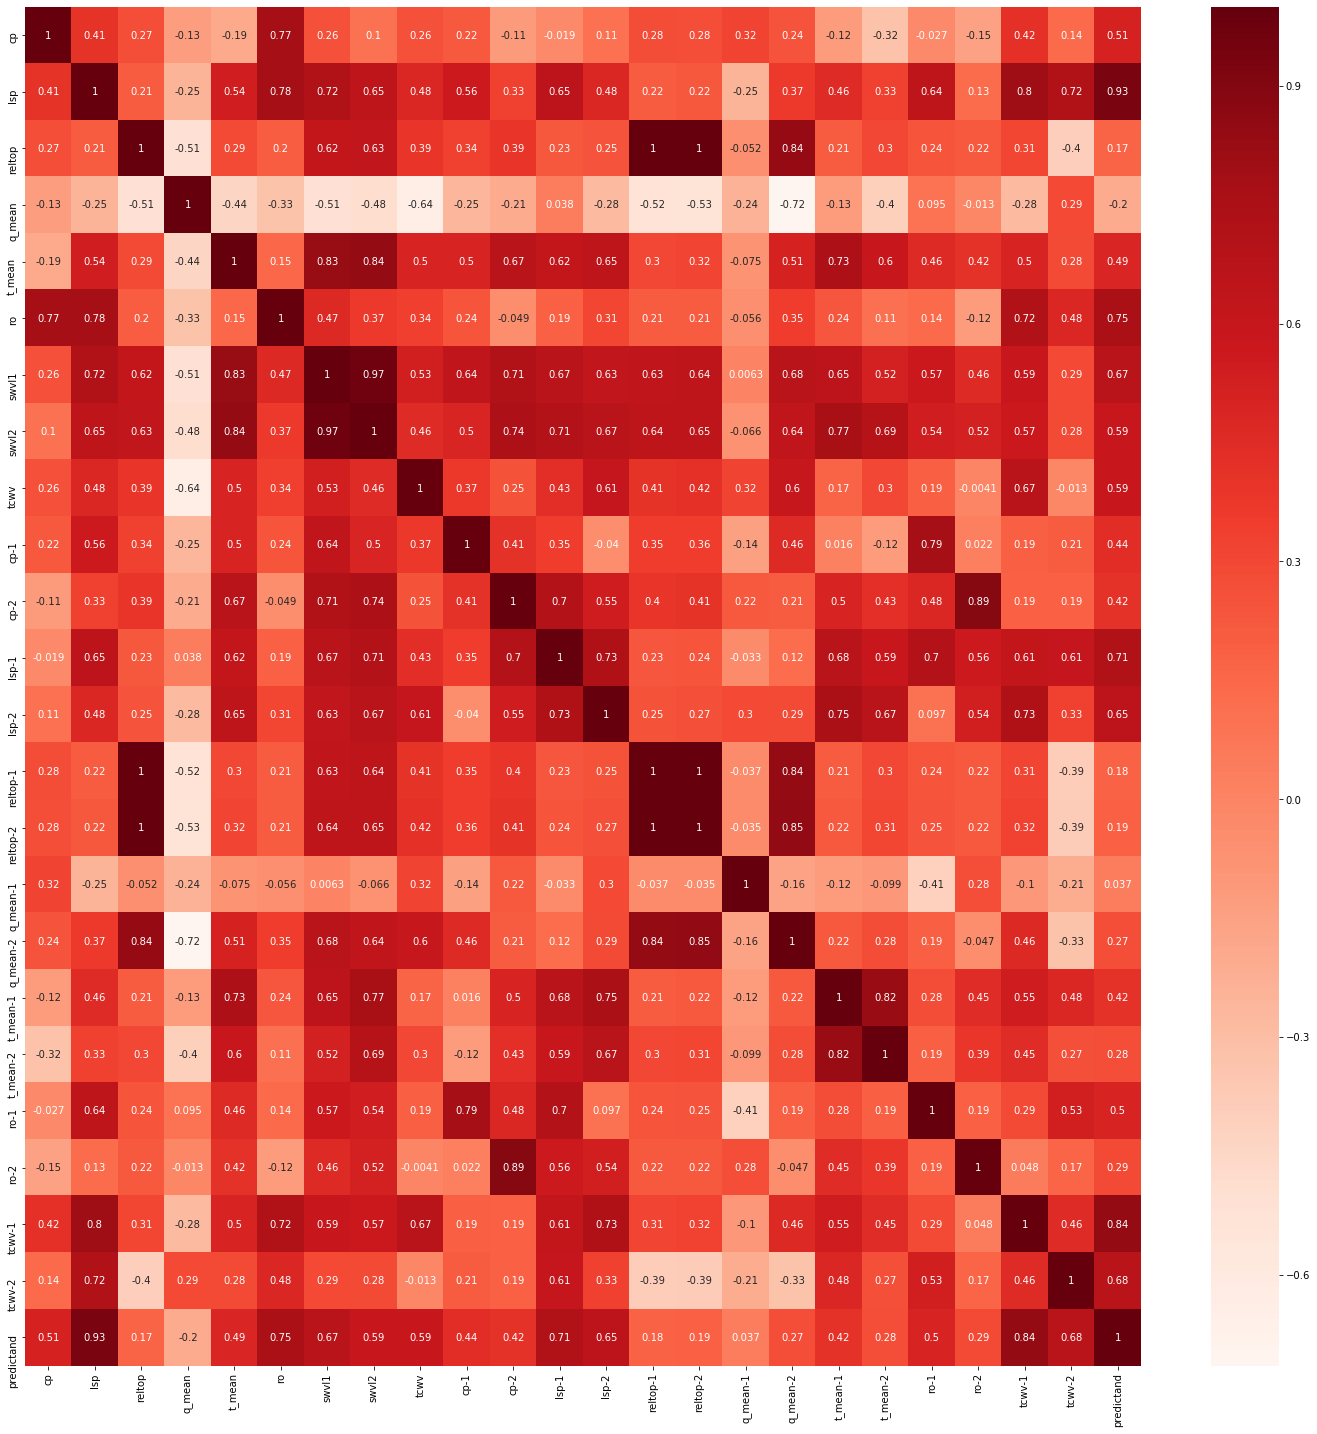

2013-05-30-2013-06-15; only days with precip > 1mm
cp            0.506106
lsp           0.930444
q_mean        0.203554
t_mean        0.487972
ro            0.752533
swvl1         0.672707
swvl2         0.587074
tcwv          0.587989
cp-1          0.437521
cp-2          0.416523
lsp-1         0.714237
lsp-2         0.652021
q_mean-2      0.274962
t_mean-1      0.416965
t_mean-2      0.275333
ro-1          0.500917
ro-2          0.285004
tcwv-1        0.841680
tcwv-2        0.675198
predictand    1.000000
Name: predictand, dtype: float64


In [63]:
timeinit = '2013-05-30'
timeend = '2013-06-15'
X, y = feature_preproc(era5=era5, glofas=glofas, timeinit=timeinit, timeend=timeend)
Xtp = X.sel(features='cp') + X.sel(features='lsp')
Xprecip = Xtp.where(Xtp>1/1000, drop=True)
X = X.where(Xprecip)
y = y.where(Xprecip)
ft = generate_heatmap(X=X, y=y, descr=f'{timeinit}-{timeend}; only days with precip > 1mm')

In [65]:
ft[ft > 0.6]

lsp           0.930444
ro            0.752533
swvl1         0.672707
lsp-1         0.714237
lsp-2         0.652021
tcwv-1        0.841680
tcwv-2        0.675198
predictand    1.000000
Name: predictand, dtype: float64

As can be seen, the resulting features take on a different take. It is not suprising, that **cp** is not contained in the stricter requirement of coef > 0.6, because at the event in question, there was largerly orographically induced precipitation (so called, Nordstau), which is contributed as **lsp**.

Additionally, **tcwv-1** and **tcwv-2** exhibit a hight correlation coefficient as well. But looking at inter-feature colinearity, we can quickly deduce that both of those variables are highly correlated with **lsp** as well (which makes perfect sense from a physical pov, due to the orographic induced lifting, moisturizing the atmosphere over extended periods of time), which means we can safely ignore those features, as their impact is already considered in **lsp**.

Although the other features exhibit not insignificant colinearity as well, they do present a different physical process, which is why they should not be neglected just because of one examplary case.

Going forward, the most interesting features to capture for flooding seem to be **lsp**, **ro**, **swvl1** as well as time lagged **lsp** (an indication for large flooding events, due to extending periods with huge amounts of precipitation, as well as **cp** for flash floods (although this last relation has to be captured in a few case examples yet, but holds some weight in the overall influence shown above).